In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import warnings

df_model_data = pd.read_csv('/home/davi/pyproject/portifolio/projeto_series_temporais-1/data/loja_1_model_data.csv')

In [2]:
# Ignorar avisos que podem poluir a saída do Grid Search
warnings.filterwarnings("ignore")

# =============================================================================
# PASSO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS
# =============================================================================
# Carregar o seu dataframe já pré-processado
df_model_data = pd.read_csv('/home/davi/pyproject/portifolio/projeto_series_temporais-1/data/loja_1_model_data.csv')

# Garantir que a coluna 'Date' seja do tipo datetime e se torne o índice
df_model_data['Date'] = pd.to_datetime(df_model_data['Date'])
df_model_data = df_model_data.set_index('Date')

# Garantir que os dados estão em ordem cronológica
df_model_data.sort_index(inplace=True)



# Preencher possíveis falhas na sequência de datas com o último valor válido
df_model_data.fillna(method='ffill', inplace=True)

print("Dados carregados e preparados com sucesso.")
print(df_model_data.head())

Dados carregados e preparados com sucesso.
            Weekly_Sales  Temperature  Fuel_Price         CPI  Unemployment  \
Date                                                                          
2010-02-05    1643690.90        42.31       2.572  211.096358         8.106   
2010-02-12    1641957.44        38.51       2.548  211.242170         8.106   
2010-02-19    1611968.17        39.93       2.514  211.289143         8.106   
2010-02-26    1409727.59        46.63       2.561  211.319643         8.106   
2010-03-05    1554806.68        46.50       2.625  211.350143         8.106   

            IsHoliday  year  month  week_of_year  sales_lag_1  sales_lag_4  \
Date                                                                         
2010-02-05      False  2010      2             5   1643690.90    1643690.9   
2010-02-12       True  2010      2             6   1643690.90    1643690.9   
2010-02-19      False  2010      2             7   1641957.44    1643690.9   
2010-02-26   

In [3]:
# =============================================================================
# PASSO 2: DEFINIÇÃO DAS VARIÁVEIS (ALVO E EXÓGENAS)
# =============================================================================
# Variável Alvo (o que queremos prever)
y = df_model_data['Weekly_Sales']

# Variáveis Externas (o que ajuda a explicar as vendas)
# Usaremos 'IsHoliday' e 'Temperature' como exemplo.
exog_vars = ['IsHoliday', 'Temperature']
X = df_model_data[exog_vars]
X['IsHoliday'] = X['IsHoliday'].astype(float) # Garantir que seja numérico

print("\nVariável Alvo (y) e Exógenas (X) definidas.")


Variável Alvo (y) e Exógenas (X) definidas.


In [4]:
# =============================================================================
# PASSO 3: DIVISÃO EM DADOS DE TREINO E TESTE
# =============================================================================
# Para séries temporais, a divisão é feita por data, sem embaralhar.
train_percentage = 0.85
split_point = int(len(df_model_data) * train_percentage)

y_train, y_test = y[:split_point], y[split_point:]
X_train, X_test = X[:split_point], X[split_point:]

print(f"\nDados divididos em {train_percentage*100}% para treino e {(1-train_percentage)*100}% para teste.")
print(f"Tamanho do treino: {len(y_train)} semanas")
print(f"Tamanho do teste: {len(y_test)} semanas")


Dados divididos em 85.0% para treino e 15.000000000000002% para teste.
Tamanho do treino: 121 semanas
Tamanho do teste: 22 semanas


In [5]:
# =============================================================================
# PASSO 4: ENCONTRAR OS MELHORES PARÂMETROS (GRID SEARCH COM AIC)
# =============================================================================
print("\nIniciando busca pelos melhores parâmetros (Grid Search)...")

# Definir os intervalos de parâmetros para testar (p, d, q)
p = d = q = range(0, 2)  # p, d, q podem ser 0 ou 1
pdq = list(itertools.product(p, d, q))

# Definir os parâmetros sazonais (P, D, Q, m)
# Vamos testar algumas combinações simples, mantendo D=1 e m=52
seasonal_pdq = [(p_s, 0, q_s, 52) for p_s in range(0, 2) for q_s in range(0, 2)]

best_aic = float("inf")
best_params = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model_temp = sm.tsa.SARIMAX(y_train,
                                        exog=X_train,
                                        order=param,
                                        seasonal_order=param_seasonal)
            results_temp = model_temp.fit(disp=False)
            
            if results_temp.aic < best_aic:
                best_aic = results_temp.aic
                best_params['order'] = param
                best_params['seasonal_order'] = param_seasonal

        except Exception as e:
            continue # Ignora combinações que causam erros

print("\nBusca finalizada!")
print(f"Melhores Parâmetros encontrados: order={best_params['order']}, seasonal_order={best_params['seasonal_order']}")
print(f"Menor AIC: {best_aic:.2f}")



Iniciando busca pelos melhores parâmetros (Grid Search)...

Busca finalizada!
Melhores Parâmetros encontrados: order=(1, 1, 1), seasonal_order=(1, 0, 0, 52)
Menor AIC: 3210.27


In [13]:
# Iniciando busca pelos melhores parâmetros (Grid Search)...

# Busca finalizada!
# Melhores Parâmetros encontrados: order=(0, 1, 1), seasonal_order=(0, 1, 1, 52)
# Menor AIC: 1737.62

best_params["order"] = (0, 1, 1)
best_params["seasonal_order"] = (0,1,1,52)

best_params

{'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 52)}

In [14]:
# =============================================================================
# PASSO 5: TREINAR O MODELO FINAL COM OS MELHORES PARÂMETROS
# =============================================================================
print("\nTreinando o modelo final com os melhores parâmetros...")

final_model = sm.tsa.SARIMAX(y_train,
                             exog=X_train,
                             order=best_params['order'],
                             seasonal_order=best_params['seasonal_order'])

final_results = final_model.fit(disp=False)
print("Modelo treinado com sucesso.")



Treinando o modelo final com os melhores parâmetros...
Modelo treinado com sucesso.


In [15]:
# =============================================================================
# PASSO 6: FAZER PREVISÕES E AVALIAR O MODELO
# =============================================================================
# Fazer a previsão para o período de teste
# É crucial fornecer as variáveis exógenas do período de teste (X_test)
forecast = final_results.get_forecast(steps=len(y_test), exog=X_test)

# Obter os valores previstos e os intervalos de confiança
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Avaliar a acurácia com a métrica MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, predicted_mean)
print(f"\nMAPE do Modelo Final: {mape:.2%}") # Formata como porcentagem


MAPE do Modelo Final: 2.74%


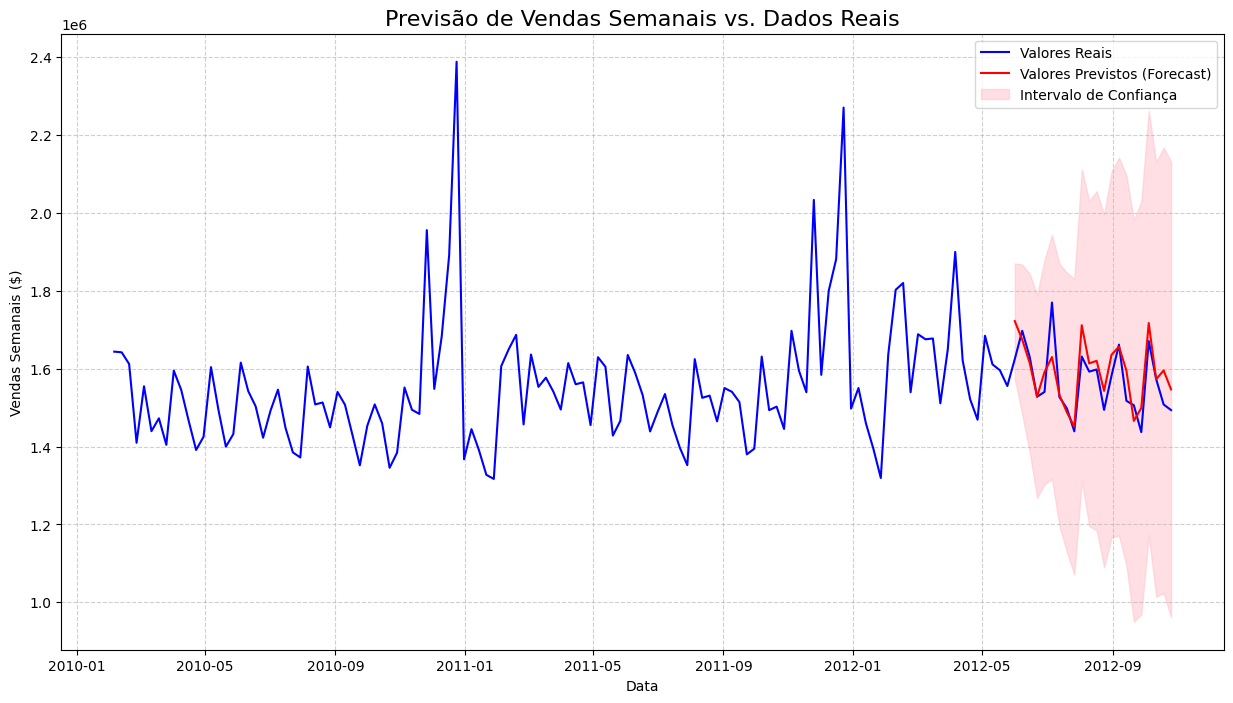


--- Sumário do Modelo Final ---
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -863.810
Date:                            Mon, 14 Jul 2025   AIC                           1737.621
Time:                                    11:10:21   BIC                           1748.718
Sample:                                02-05-2010   HQIC                          1742.018
                                     - 05-25-2012                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
IsHoliday    3.912e-07   2.73e+05   1.43e-12      1.000   -5.35e+05    5.35e+05

In [16]:
# =============================================================================
# PASSO 7: VISUALIZAR E INTERPRETAR OS RESULTADOS
# =============================================================================
# Plotar os resultados
plt.figure(figsize=(15, 8))
plt.plot(y.index, y, label='Valores Reais', color='blue')
plt.plot(predicted_mean.index, predicted_mean, label='Valores Previstos (Forecast)', color='red')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.5, label='Intervalo de Confiança')

plt.title('Previsão de Vendas Semanais vs. Dados Reais', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Vendas Semanais ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Imprimir o sumário do modelo para interpretar os coeficientes
print("\n--- Sumário do Modelo Final ---")
print(final_results.summary())